In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join, exists, isdir
from glob import glob
from typing import List, Union

import torch
import cv2
import numpy as np
from PIL import Image

from relfm.utils.visualize import show_grid_of_images, show_keypoint_matches, show_single_image, draw_kps_on_image, COLORS
from relfm.utils.matching import mnn_matcher, add_kps_to_image, find_matches
from lib.r2d2.extract import extract_keypoints_modified

from relfm.utils.geometry import get_image_corners, apply_homography_to_keypoints, get_2D_rotation_matrix

In [3]:
DATA_ROOT = "/home/lcur1325/datasets/hpatches-sequences-release/"

### Select a sample folder to test

In [4]:
# category = "v_churchill"
category = "v_home"
category_folder = join(DATA_ROOT, category)

image_paths = sorted(glob(join(category_folder, "*.ppm")))
homography_paths = sorted(glob(join(category_folder, "H_*_*")))

In [5]:
img1_path = image_paths[0]
img2_path = image_paths[3]

H_path = homography_paths[3 - 1]

In [6]:
img1_path, img2_path, H_path

('/home/lcur1325/datasets/hpatches-sequences-release/v_home/1.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_home/4.ppm',
 '/home/lcur1325/datasets/hpatches-sequences-release/v_home/H_1_4')

### Load a pair of images and homography $H$

In [7]:
# load images
img1, img2 = Image.open(img1_path), Image.open(img2_path)

# load homography: transform from image 1 to image 2
H = np.loadtxt(H_path)

In [8]:
# sanity checking H

# load corners as keypoints in image 1
kps1 = get_image_corners(img1)

# add another random point in the image for better visualization
kps1 = np.vstack([kps1, np.array([360, 540.])])

# add these kps to image 1
img1_with_kps = draw_kps_on_image(img1, kps1, radius=15, return_as="PIL")

# apply homography to kps in image 1 to obtain kps in image 2
kps2 = apply_homography_to_keypoints(kps1, H)

# add the newly estimated keypoints to image 2
img2_with_kps = draw_kps_on_image(img2, kps2, radius=15, return_as="PIL")

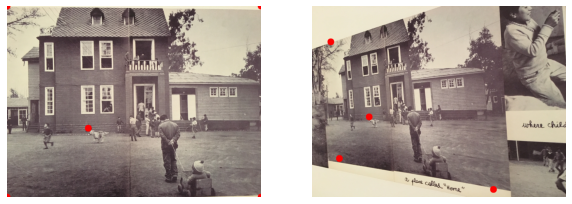

In [9]:
show_grid_of_images([img1_with_kps, img2_with_kps], n_cols=2, figsize=(10, 8))

In [10]:
H

array([[ 3.1219e-01,  4.5878e-02,  8.3286e+01],
       [-1.7918e-01,  6.1590e-01,  1.5849e+02],
       [-3.7093e-04,  1.0056e-05,  9.9747e-01]])

### Apply rotation (as a homography $H_{R}$?) to image 2

Let's say we are given a 2D rotation matrix $R$ and a keypoint $\mathbf{x} \in I$ (image). If I rotate the image anticlockwise about the center, then what transform $T$ do I apply to $\mathbf{x}$ such that the new point $\mathbf{x}' = T(\mathbf{x})$.

Let $C_{0} (=[W/2, H/2] )$ be the center of the image. A given point $\mathbf{x}$ is w.r.t. the image-space (with origin at top-left corner). We can get the same point in coordinate with $C_{0}$ as the origin by $\bar{\mathbf{x}} = \mathbf{x} - C_{0}$. In this new coordinate system, we can apply the roation matrix as a matrix multiplication.

$$
\bar{\mathbf{x}'} = R\bar{\mathbf{x}} \\
\mathbf{x}' - C_{0} = R(\mathbf{x} - C_{0}) \\
\mathbf{x}'  = R(\mathbf{x} - C_{0}) + C_{0}\\
\mathbf{x}' = R\mathbf{x} + (I - R) C_{0} \\
\mathbf{x}'_{\text{homo}} = \begin{pmatrix}R & \mathbf{t} \\ \mathbf{0} & 1\end{pmatrix}\mathbf{x}_{\text{homo}} \\
\text{where, } \mathbf{t} = (I - R) C_{0}
$$

Alternate simpler view: Move it in the coordinate frame of the image center, then rotate, then translate back.
$$
\mathbf{x}'  = R(\mathbf{x} - C_{0}) + C_{0}\\
$$

Alternate: One can just multiple a set of three matrices (bring it in center-of-image reference frame, rotate, translate back)

In [11]:
rotation = 30

R2D = get_2D_rotation_matrix(rotation)

# construct homography from given 2D rotation matrix
HR = np.eye(3)
HR[:2, :2] = R2D

# apply center correction: see notes for derivation

# define the center of the image
width, height = img2.size
C0 = np.array([width / 2., height / 2.])

# add the correction translation factor
t = (np.eye(2) - R2D) @ C0
HR[:2, 2] = t

In [12]:
HR

array([[   0.8660254 ,    0.5       , -135.82230233],
       [  -0.5       ,    0.8660254 ,  338.1042669 ],
       [   0.        ,    0.        ,    1.        ]])

In [13]:
# apply the estimated rotation homograhpy to kps in image 2
kps2_rotated = apply_homography_to_keypoints(kps2, HR)

# add the newly rotated keypoints to image 2 which already had keypoints
img2_with_kps_rotated = draw_kps_on_image(
    img2_with_kps, kps2_rotated, radius=15, return_as="PIL", color=(0, 0, 255),
)

# add the center of the image as well
img2_with_kps_rotated = cv2.circle(
    np.asarray(img2_with_kps_rotated), (int(C0[0]), int(C0[1])), radius=15, thickness=-1, color=(255, 255, 255),
)

# sanity check: add a circle passing through a special keypoint
kp = kps2[-1]
radius = np.linalg.norm(kp - C0)
img2_with_kps_rotated_and_circle = cv2.circle(
    np.asarray(img2_with_kps_rotated), (int(C0[0]), int(C0[1])), radius=int(radius), thickness=2, color=COLORS["red"],
)

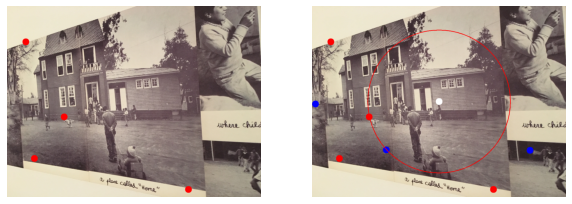

In [14]:
show_grid_of_images([img2_with_kps, img2_with_kps_rotated_and_circle], n_cols=2, figsize=(10, 8))

In [15]:
# rotate the image and visualze the rotated keypoints
img2_with_kps_rotated = img2_with_kps.rotate(rotation).copy()

# add the rotated keypoints to the rotated image
img2_with_kps_rotated_with_kps = draw_kps_on_image(
    img2_with_kps_rotated, kps2_rotated, radius=15, return_as="PIL", color=(0, 0, 255),
)

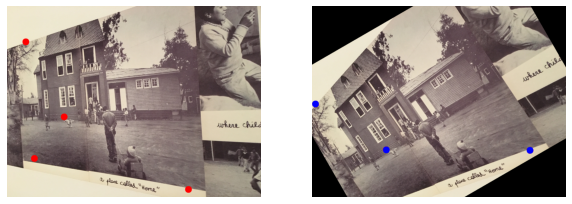

In [16]:
show_grid_of_images([img2_with_kps, img2_with_kps_rotated_with_kps], n_cols=2, figsize=(10, 8))

### Combine $H$ and $H_R$ correctly

In [17]:
# HR = T2 @ R @ T1

In [18]:
# combine by matrix multiplication
H_combined = HR @ H

# rotate image 2
img2_rotated = img2.rotate(rotation).copy()

# apply combined transform to kps in image 1
kps2_combined = apply_homography_to_keypoints(kps1, H_combined)

# add the newly estimated keypoints to image 2
img2_with_kps_combined = draw_kps_on_image(img2_rotated, kps2_combined, radius=15, return_as="PIL")

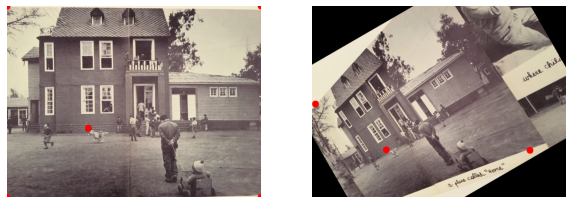

In [19]:
show_grid_of_images([img1_with_kps, img2_with_kps_combined], n_cols=2, figsize=(10, 8))

### Visualize transformation of dense keypoints

In [20]:
width, height = img1.size

In [21]:
width, height

(1126, 845)

In [22]:
num_points_per_axis = 100
x_coordinates = np.linspace(0, width, num_points_per_axis)
y_coordinates = np.linspace(0, height, num_points_per_axis)

In [23]:
X, Y = np.meshgrid(x_coordinates, y_coordinates)

kps1 = []
for i in range(num_points_per_axis):
    for j in range(num_points_per_axis):
        kps1.append([X[i, j], Y[i, j]])
kps1 = np.array(kps1)

In [24]:
kps1.shape

(10000, 2)

In [25]:
# sanity checking H

# add another random point in the image for better visualization
kps1 = np.vstack([kps1, np.array([360, 540.])])

# add these kps to image 1
img1_with_kps = draw_kps_on_image(img1, kps1, radius=3, return_as="PIL")

# apply homography to kps in image 1 to obtain kps in image 2
kps2 = apply_homography_to_keypoints(kps1, H_combined)

# add the newly estimated keypoints to image 2
img2_with_kps = draw_kps_on_image(img2_rotated, kps2, radius=3, return_as="PIL")

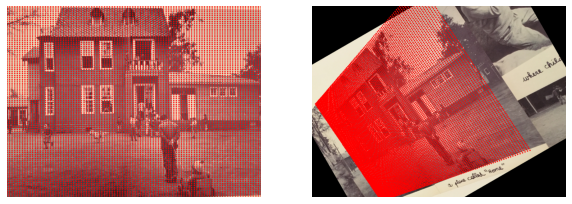

In [26]:
show_grid_of_images([img1_with_kps, img2_with_kps], n_cols=2, figsize=(10, 8))